In [6]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

1.12.1


In [486]:
from sklearn.metrics.cluster import adjusted_rand_score

# Overview of Cora & Citeseer

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

len(data.x)


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


2708

In [946]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data2 = dataset[0]  # Get the first graph object.

print()
print(data2)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data2.num_nodes}')
print(f'Number of edges: {data2.num_edges}')
print(f'Average node degree: {data2.num_edges / data2.num_nodes:.2f}')
print(f'Number of training nodes: {data2.train_mask.sum()}')
print(f'Training node label rate: {int(data2.train_mask.sum()) / data2.num_nodes:.2f}')
print(f'Has isolated nodes: {data2.has_isolated_nodes()}')
print(f'Has self-loops: {data2.has_self_loops()}')
print(f'Is undirected: {data2.is_undirected()}')

len(data2.x)


Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


3327

In [760]:
import time

In [767]:
import numpy as np
from scipy.optimize import linear_sum_assignment as linear_assignment

# Find best hyperparameter - Cora

For the section below, I have run it 10 times with seeds in order to capture any variations, but because I found out that the values and plots remained relatively constant, I only put the code for one of the runs for clarity and for neatness sake. 

## Reduce dimensionality by PCA

In [957]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(data.x.t())
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

dataset_pca = pd.DataFrame(pca_2.components_,  index=['x', 'y'])
dataset = dataset_pca.transpose()


Explained variation per principal component: [0.04824656 0.0245916 ]
Cumulative variance explained by 2 principal components: 7.28%


### K-Means & Agglomerative

In [958]:
list1 = []
for i in range(0, len(dataset)):
    list1.append([dataset.iloc[i, 0], dataset.iloc[i, 1]])
    
list1 = np.array(list1)


Find out the best number of clusters for kmeans using the elbow method.

In [959]:
wcss = [] #wcss is sum of squared distance between each point and the centroid in a cluster
for i in range(1, 30): 
    kmeans = KMeans(n_clusters = i, n_init=200)
    kmeans.fit(list1) 
    wcss.append(kmeans.inertia_) #calculate the w

Text(0.5, 0, 'No. of clusters')

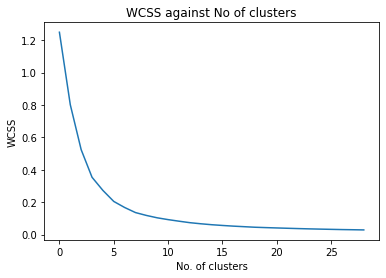

In [960]:
plt.plot(wcss)
plt.title("WCSS against No of clusters")
plt.ylabel("WCSS")
plt.xlabel("No. of clusters")

Based on the plot and from prior knowledge, we can determine that the ideal no of clusters is 7.

### DBSCAN

Before we use DBSCAN to perform clustering, we need to find a way to tune DBSCAN's hyperparameters.

One method used to estimate the optimal epsilon value is to use nearest neighbor distances. 
The following paper, describes an approach for automatically determining the optimal value for Eps.

https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In layman’s terms, we find a suitable value for epsilon by calculating the distance to the nearest n points for each point, sorting and plotting the results. Then we look to see where the change is most pronounced (think of the angle between your arm and forearm) and select that as epsilon.

A simple rule to select k would be n^(1/2) for K-Nearest Neighbour. https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/

In [963]:
round(2708**0.5,1)

52.0

In [986]:
neigh = NearestNeighbors(n_neighbors=52)
nbrs = neigh.fit(list1)
distances, indices = nbrs.kneighbors(list1)

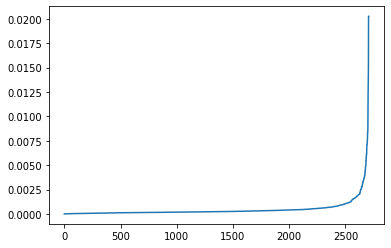

In [987]:

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

From the above plot, we can see that the highest change occurs at 0.0025.

To select the most optimal minimum samples for DBSCAN, we can use the following rule of thumb:

- The larger the data set, the larger the value of MinPts should be
- If the data set is noisier, choose a larger value of MinPts
- Generally, MinPts should be greater than or equal to the dimensionality of the data set
- For 2-dimensional data, use DBSCAN’s default value of MinPts = 4 (Ester et al., 1996).
- If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).

Since the dimensionality of the data is 2, we use min pts as 4.

## Reducing dimensionality using t-SNE

t-SNE stands for t-distributed Stochastic Neighbor Embedding, which tells the following :
- Stochastic → not definite but random probability
- Neighbor → concerned only about retaining the variance of neighbor points
- Embedding → plotting data into lower dimensions

In short, t-SNE is a machine learning algorithm that generates slightly different results each time on the same data set, focusing on retaining the structure of neighbor points.

A simple to rule to select perplexity (t-SNE's hyperparameter) would be N^1/2.
https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868

This means the more the number of data points, the higher the perplexity.

In [966]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=52).fit_transform(data.x)

In [967]:
dataset_tsne = pd.DataFrame(X_embedded, columns = ['x', 'y'])

### K-Means & Agglomerative

In [995]:
np.random.seed(12)

In [996]:
list2 = []
for i in range(0, len(dataset_tsne)):
    list2.append([dataset_tsne.iloc[i, 0], dataset_tsne.iloc[i, 1]])
    
list2 = np.array(list2)

In [997]:
wcss2 = [] #wcss is sum of squared distance between each point and the centroid in a cluster
for i in range(1, 30): 
    kmeans = KMeans(n_clusters = i, n_init=200)
    kmeans.fit(list2) 
    wcss2.append(kmeans.inertia_) #calculate the w

Text(0.5, 0, 'No. of clusters')

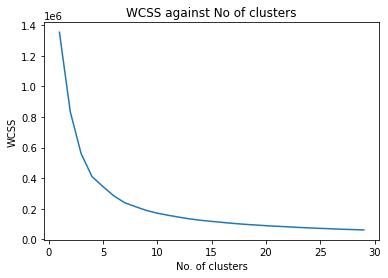

In [998]:
plt.plot(list(yrange), list(wcss2))
plt.title("WCSS against No of clusters")
plt.ylabel("WCSS")
plt.xlabel("No. of clusters")

Based on the plot and from prior knowledge, we can determine that the ideal no of clusters is 7.

### DBSCAN

In [999]:
round(math.sqrt(2708),2)

52.04

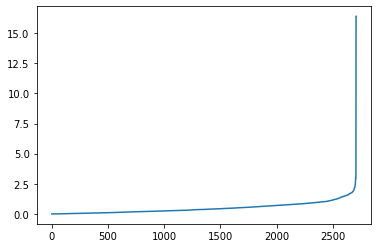

In [1000]:
neigh = NearestNeighbors(n_neighbors=52)
nbrs = neigh.fit(list2)
distances, indices = nbrs.kneighbors(list2)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

From the elbow plot, we can set epsilon as 3

# Find best hyperparameter - Citeseer

For the section below, I have run it 10 times with seeds in order to capture any variations, but because I found out that the values and plots remained relatively constant, I only put the code for one of the runs for clarity and for neatness sake.

## Reduce dimensionality by PCA

In [974]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(data2.x.t())
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

dataset2_pca = pd.DataFrame(pca_2.components_,  index=['x', 'y'])
dataset2 = dataset2_pca.transpose()


Explained variation per principal component: [0.03779293 0.01049112]
Cumulative variance explained by 2 principal components: 4.83%


### K-Means & Agglomerative

In [975]:
list1 = []
for i in range(0, len(dataset)):
    list1.append([dataset.iloc[i, 0], dataset.iloc[i, 1]])
    
list1 = np.array(list1)


Find out the best number of clusters for kmeans using the elbow method.

In [976]:
wcss = [] #wcss is sum of squared distance between each point and the centroid in a cluster
for i in range(1, 30): 
    kmeans = KMeans(n_clusters = i, n_init=200)
    kmeans.fit(list1) 
    wcss.append(kmeans.inertia_) #calculate the w

Text(0.5, 0, 'No. of clusters')

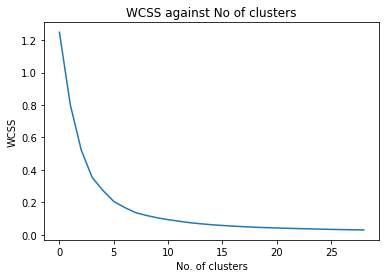

In [977]:
plt.plot(wcss)
plt.title("WCSS against No of clusters")
plt.ylabel("WCSS")
plt.xlabel("No. of clusters")

Based on the plot and from prior knowledge, we can determine that the ideal no of clusters is 6.

### DBSCAN

Before we use DBSCAN to perform clustering, we need to find a way to tune DBSCAN's hyperparameters.

One method used to estimate the optimal epsilon value is to use nearest neighbor distances. 
The following paper, describes an approach for automatically determining the optimal value for Eps.

https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In layman’s terms, we find a suitable value for epsilon by calculating the distance to the nearest n points for each point, sorting and plotting the results. Then we look to see where the change is most pronounced (think of the angle between your arm and forearm) and select that as epsilon.

A simple rule to select k would be n^(1/2) for K-Nearest Neighbour. https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/

In [1001]:
round(3327**0.5,1)

57.7

In [1006]:
neigh = NearestNeighbors(n_neighbors=57)
nbrs = neigh.fit(list1)
distances, indices = nbrs.kneighbors(list1)

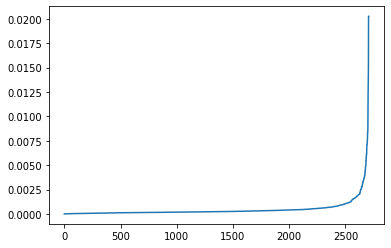

In [1007]:

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

From the above plot, we can see that the highest change occurs at 0.0020.

To select the most optimal minimum samples for DBSCAN, we can use the following rule of thumb:

- The larger the data set, the larger the value of MinPts should be
- If the data set is noisier, choose a larger value of MinPts
- Generally, MinPts should be greater than or equal to the dimensionality of the data set
- For 2-dimensional data, use DBSCAN’s default value of MinPts = 4 (Ester et al., 1996).
- If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).

Since the dimensionality of the data is 2, we use min pts as 4.

## Reducing dimensionality using t-SNE

t-SNE stands for t-distributed Stochastic Neighbor Embedding, which tells the following :
- Stochastic → not definite but random probability
- Neighbor → concerned only about retaining the variance of neighbor points
- Embedding → plotting data into lower dimensions

In short, t-SNE is a machine learning algorithm that generates slightly different results each time on the same data set, focusing on retaining the structure of neighbor points.

A simple to rule to select perplexity (t-SNE's hyperparameter) would be N^1/2.
https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868

This means the more the number of data points, the higher the perplexity.

In [1008]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=52).fit_transform(data2.x)

In [1009]:
dataset_tsne = pd.DataFrame(X_embedded, columns = ['x', 'y'])

### K-Means & Agglomerative

In [1010]:
list2 = []
for i in range(0, len(dataset_tsne)):
    list2.append([dataset_tsne.iloc[i, 0], dataset_tsne.iloc[i, 1]])
    
list2 = np.array(list2)

In [1011]:
wcss2 = [] #wcss is sum of squared distance between each point and the centroid in a cluster
for i in range(1, 30): 
    kmeans = KMeans(n_clusters = i, n_init=200)
    kmeans.fit(list2) 
    wcss2.append(kmeans.inertia_) #calculate the w

Text(0.5, 0, 'No. of clusters')

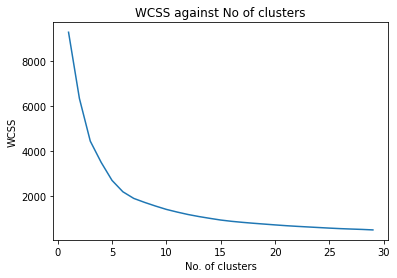

In [1012]:
plt.plot(list(yrange), list(wcss2))
plt.title("WCSS against No of clusters")
plt.ylabel("WCSS")
plt.xlabel("No. of clusters")

Based on the plot and from prior knowledge, we can determine that the ideal no of clusters is 6.

### DBSCAN

In [1013]:
round(math.sqrt(3327),2)

57.68

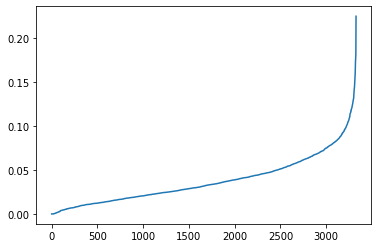

In [1014]:
neigh = NearestNeighbors(n_neighbors=57)
nbrs = neigh.fit(list2)
distances, indices = nbrs.kneighbors(list2)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

From the elbow plot, we can set epsilon as 0.13.

# Cora

In [795]:
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)
# transform min to max because linear assignment found min cost

In [796]:
def clustering_accuracy(cost_matrix, total, row_ind, col_ind):
    return cost_matrix[row_ind, col_ind].sum()/total

In [834]:
def accuracy(labels, data):
    num_true_clusters = data.num_classes
    nodes_in_comm = []
    for i in range(0, len(np.unique(labels))):
        nodes_in_comm.append([])
    
    count = 0
    for node in labels:
        nodes_in_comm[node].append(count)
        count = count+1
    cost_matrix = []
    for cluster in nodes_in_comm:
        count = [0]*num_true_clusters
        for node in cluster:
            count[data[0].y.numpy()[node]]+=1
        cost_matrix.append(count)
    cost_matrix = np.array(cost_matrix)
      # count true labels for each cluster
    print(cost_matrix)
    cm = np.array(_make_cost_m(np.array(cost_matrix)))
    row_ind, col_ind = linear_assignment(cm)
    return clustering_accuracy(cost_matrix, data[0].num_nodes, row_ind, col_ind)



SEED 0

K-MEANS PCA

[[ 13   9   7  10   3   8   4]
 [ 99  30 174 290 263 154  83]
 [  2   1  20  20   6   0   0]
 [  1   2   0   3   1   1   2]
 [ 27  12 146 263 101  23   5]
 [171 133  35  96  16 105  76]
 [ 38  30  36 136  36   7  10]]

Agglomerative PCA Ward

[[121  38 245 377 329 173  86]
 [ 16  11  10  15   6  11   6]
 [  2   1  20  19   6   0   0]
 [ 89  70  48 168  44  28  31]
 [  1   1   0   2   0   0   1]
 [  4   4  73 174  34   4   2]
 [118  92  22  63   7  82  54]]

Agglomerative PCA Complete

[[ 15  10   8  14   3  10   5]
 [  0   0   8   5   2   0   0]
 [  3   0   2   2   2   1   1]
 [  1   1   0   2   0   0   1]
 [322 196 291 552 353 280 170]
 [  0   1   0   1   1   1   1]
 [ 10   9 109 242  65   6   2]]

Agglomerative PCA Single

[[  1   1   0   1   0   0   1]
 [  0   0   1   0   0   0   0]
 [350 215 416 815 425 296 178]
 [  0   0   0   1   0   0   0]
 [  0   0   1   0   0   0   0]
 [  0   1   0   1   1   1   1]
 [  0   0   0   0   0   1   0]]

Agglomerative PCA Average

[[123 147 192 106  56  98 129]
 [ 44  12  26 188 287  19   5]
 [163  11   6  82  52  19   3]
 [  0   1   0   0   0   0   0]
 [  9  20 130  63  18 162  43]
 [  0   1   0   0   0   0   0]
 [ 12  25  64 379  13   0   0]]

DBSCAN tSNE

[[348 212 408 798 405 292 171]
 [  0   0   0   4   0   0   0]
 [  0   0   0   0   0   3   2]
 [  0   0   4   0   0   0   0]
 [  0   0   0   0   1   0   3]
 [  0   3   0   1   1   0   0]
 [  0   0   0   2   2   0   0]
 [  3   2   6  13  17   3   4]]
SEED 3

K-MEANS PCA

[[171 133  35  96  16 105  76]
 [  1   2   0   3   1   1   2]
 [ 27  12 146 263 101  23   5]
 [ 99  30 174 290 263 154  83]
 [  2   1  20  20   6   0   0]
 [ 38  30  36 136  36   7  10]
 [ 13   9   7  10   3   8   4]]

Agglomerative PCA Ward

[[ 16  11  10  15   6  11   6]
 [113  34 217 353 305 165  85]
 [  2   1  20  19   6   0   0]
 [177 135  31  89  16 107  82]
 [  1   1   0   2   0   0   1]
 [ 12   8 101 198  58  12   3]
 [ 30  27  39 142  35   3   3]]

Agglomerative PCA Complete

[[  4   

[[ 74   3   4  42  93  14  13]
 [ 98 150  34 485  37  60  33]
 [ 27  39 160  68  45  40  12]
 [ 81   8   9  87 168  19  75]
 [  0   1   0   0   0   0   0]
 [ 45   6 191  69  66  19  45]
 [ 26  10  20  67  17 146   2]]

Agglomerative tSNE single

[[349 215 416 816 425 298 178]
 [  1   0   0   0   0   0   2]
 [  0   0   2   0   0   0   0]
 [  0   1   0   0   0   0   0]
 [  1   0   0   0   1   0   0]
 [  0   1   0   0   0   0   0]
 [  0   0   0   2   0   0   0]]

Agglomerative tSNE average

[[209  11  28 190 304  68 108]
 [ 41 146 321  51  45  32  49]
 [ 51  29  22 440  25  11   9]
 [  0   1   0   0   0   0   0]
 [ 31  21  16  92  20 173  10]
 [  0   1   0   0   0   0   0]
 [ 19   8  31  45  32  14   4]]

DBSCAN tSNE

[[346 208 403 780 410 291 176]
 [  0   0   1   1   0   3   0]
 [  1   2   1   0   1   0   0]
 [  0   0   0   8   0   0   0]
 [  0   0   4   0   0   0   0]
 [  0   0   0   5   1   0   0]
 [  0   0   0   0   4   0   0]
 [  0   0   0   4   0   0   0]
 [  4   7   9  20  10   4  

[[ 42 149  37 164  48  54  22]
 [182  18  15  47  21  44 100]
 [ 62   6   1  66  44 169  13]
 [ 17  14 277  30   9   8  34]
 [ 22  24  81 149  39  16   6]
 [ 18   1   3  98 204   7   3]
 [  8   5   4 264  61   0   2]]

Agglomerative tSNE ward

[[ 16   2   3  96 214 141   7]
 [ 13  26 311  40  25  18  38]
 [180  47  20  99  38  74  47]
 [ 21  22  61 128  80  13   5]
 [ 27 109  10 240  42  31   9]
 [  7   3   2 197  15   1   2]
 [ 87   8  11  18  12  20  72]]

Agglomerative tSNE Complete

[[ 31  38  36 365  96  23  12]
 [198  27  32  55  24  42 132]
 [ 99 115  16 150  97 163  23]
 [ 10  33 332  45  19  16   8]
 [  0   1   0   0   0   0   0]
 [  0   1   0   0   0   0   0]
 [ 13   2   2 203 190  54   5]]

Agglomerative tSNE single

[[350 215 416 818 424 296 178]
 [  0   0   2   0   0   0   0]
 [  1   0   0   0   0   0   2]
 [  0   1   0   0   0   0   0]
 [  0   0   0   0   2   0   0]
 [  0   1   0   0   0   0   0]
 [  0   0   0   0   0   2   0]]

Agglomerative tSNE average

[[ 36 147 100 4

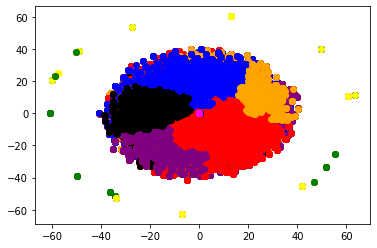

In [850]:
RandIndexKMeansPCA = []
RandIndexDBSCANPCA = []
RandIndexAgglomerativePCA = []
RandIndexKMeanstSNE = []
RandIndexDBSCANtSNE = []
RandIndexAgglomerativetSNE = []
TimeKMeansPCA = []
TimeDBSCANPCA = []
TimeAgglomerativePCA = []
TimeKMeanstSNE = []
TimeDBSCANtSNE = []
TimeAgglomerativetSNE =[]

seeds = [1,12,123,1234,12345,123456,1234567,12345678,123456789,1234567890]

datasettrue = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

data = datasettrue[0]

for i in range(0, 10):
    Agglomerative = []
    AgglomerativeTime = []
    print("SEED", i)
    print()
    np.random.seed(seeds[i])
    #K-MEANS PCA
    print("K-MEANS PCA")
    print()
    pca_2 = PCA(n_components=2)
    pca_2_result = pca_2.fit_transform(data.x.t())
    dataset_pca = pd.DataFrame(pca_2.components_,  index=['x', 'y'])
    dataset = dataset_pca.transpose()
    list1 = []
    for i in range(0, len(dataset)):
        list1.append([dataset.iloc[i, 0], dataset.iloc[i, 1]])
    list1 = np.array(list1)
    start = time.time()
    kmeans = KMeans(n_clusters = 7, n_init=200).fit(list1)
    end = time.time()
    label = kmeans.labels_
    
    RandIndexKMeansPCA.append(accuracy(label, datasettrue))
    TimeKMeansPCA.append(end-start)
    print()
    print("Agglomerative PCA Ward")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=7, linkage="ward")
    agglomerative.fit(list1)
    end = time.time()

    label2 = agglomerative.labels_
    
    AgglomerativeTime.append(end-start)
    Agglomerative.append(accuracy(label2, datasettrue))
    
    print()
    print("Agglomerative PCA Complete")
    print()
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=7, linkage="complete")
    agglomerative.fit(list1)
    end = time.time()

    label2 = agglomerative.labels_
    
    AgglomerativeTime.append(end-start)
    Agglomerative.append(accuracy(label2, datasettrue))
    
    print()
    print("Agglomerative PCA Single")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=7, linkage="single")
    agglomerative.fit(list1)
    end = time.time()

    
    label2 = agglomerative.labels_
    AgglomerativeTime.append(end-start)
    Agglomerative.append(accuracy(label2, datasettrue))
    
    print()
    print("Agglomerative PCA Average")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=7, linkage="average")
    agglomerative.fit(list1)
    end = time.time()

    
    AgglomerativeTime.append(end-start)
    Agglomerative.append(accuracy(label2, datasettrue))
    
    RandIndexAgglomerativePCA.append(Agglomerative)
    TimeAgglomerativePCA.append(AgglomerativeTime)
    
    print()
    print("DBSCAN PCA")
    print()
    
    start = time.time()
    clustering = DBSCAN(eps=0.0025, min_samples=4).fit(list1)
    end = time.time()
    label4 = clustering.labels_

    unique, counts = np.unique(label4, return_counts = True)

    dict(zip(unique, counts))

    colours = ['red', 'blue', 'purple', 'pink', 'green', 'yellow', 'orange', 'black', 'brown', 'cyan', 'magenta', 'gray', 'silver', 'gold', 'teal']
    for i in range(0, len(unique)):
        plt.scatter(list1[label4==unique[i], 0], list1[label4 == unique[i],1], c =colours[i])

    
    TimeDBSCANPCA.append(end-start)
    RandIndexDBSCANPCA.append(accuracy(label4, datasettrue))
    
    print()
    print("K-Means tSNE")
    print()
    
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=52).fit_transform(data.x)
    dataset_tsne = pd.DataFrame(X_embedded, columns = ['x', 'y'])
    
    list2 = []
    for i in range(0, len(dataset_tsne)):
        list2.append([dataset_tsne.iloc[i, 0], dataset_tsne.iloc[i, 1]])
    
    list2 = np.array(list2)
    
    start = time.time()
    kmeans = KMeans(n_clusters = 7, n_init=200).fit(list2)
    end = time.time()
    label = kmeans.labels_
    
    TimeKMeanstSNE.append(end-start)
    RandIndexKMeanstSNE.append(accuracy(label, datasettrue))
    
    print()
    print("Agglomerative tSNE ward")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=7, linkage="ward")
    agglomerative.fit(list2)
    end = time.time()

    label2 = agglomerative.labels_
    
    Agglomerative = []
    AgglomerativeTime = []
    
    AgglomerativeTime.append(end-start)
    Agglomerative.append(accuracy(label2, datasettrue))
    
    print()
    print("Agglomerative tSNE Complete")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=7, linkage="complete")
    agglomerative.fit(list2)
    end = time.time()

    label2 = agglomerative.labels_
    
    AgglomerativeTime.append(end-start)
    Agglomerative.append(accuracy(label2, datasettrue))
    
    print()
    print("Agglomerative tSNE single")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=7, linkage="single")
    agglomerative.fit(list2)
    end = time.time()

    label2 = agglomerative.labels_
    
    
    AgglomerativeTime.append(end-start)
    Agglomerative.append(accuracy(label2, datasettrue))
    
    print()
    print("Agglomerative tSNE average")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=7, linkage="average")
    agglomerative.fit(list2)
    end = time.time()

    label2 = agglomerative.labels_
    
    AgglomerativeTime.append(end-start)
    Agglomerative.append(accuracy(label2, datasettrue))
    
    RandIndexAgglomerativetSNE.append(Agglomerative)
    TimeAgglomerativetSNE.append(AgglomerativeTime)
    
    print()
    print("DBSCAN tSNE")
    print()
    
    start = time.time()
    clustering = DBSCAN(eps=3, min_samples=4).fit(list2)
    label4 = clustering.labels_
    end = time.time()

    unique, counts = np.unique(label4, return_counts = True)

    dict(zip(unique, counts))
    
    for i in range(0, len(unique)):
        plt.scatter(list1[label4==unique[i], 0], list1[label4 == unique[i],1], c =colours[i])
        
    
    RandIndexDBSCANtSNE.append(accuracy(label4, datasettrue))
    TimeDBSCANtSNE.append(end-start)
    
    
    
    
    
    
    
    
    

In [954]:
print(RandIndexKMeansPCA)
print()
print(RandIndexDBSCANPCA)
print()
print(RandIndexAgglomerativePCA)
print()
print(RandIndexKMeanstSNE)
print()
print(RandIndexDBSCANtSNE)
print()
print(RandIndexAgglomerativetSNE)
print()
print(TimeKMeansPCA)
print()
print(TimeDBSCANPCA)
print()
print(TimeAgglomerativePCA)
print()
print(TimeKMeanstSNE)
print()
print(TimeDBSCANtSNE)
print()
print(TimeAgglomerativetSNE)
print()

[0.2795420974889217, 0.2799113737075332, 0.2795420974889217, 0.2795420974889217, 0.2799113737075332, 0.2795420974889217, 0.2795420974889217, 0.2795420974889217, 0.2795420974889217, 0.2799113737075332]

[0.2961595273264402, 0.2961595273264402, 0.2961595273264402, 0.2961595273264402, 0.2961595273264402, 0.2961595273264402, 0.2961595273264402, 0.2961595273264402, 0.2961595273264402, 0.2961595273264402]

[[0.26698670605613, 0.2514771048744461, 0.30243722304283605, 0.30428360413589367], [0.2625553914327917, 0.2972673559822747, 0.30243722304283605, 0.30428360413589367], [0.26292466765140327, 0.26329394387001476, 0.30243722304283605, 0.30132939438700146], [0.2728951255539143, 0.2972673559822747, 0.30243722304283605, 0.30280649926144754], [0.2795420974889217, 0.24741506646971936, 0.30243722304283605, 0.30428360413589367], [0.26698670605613, 0.2972673559822747, 0.30243722304283605, 0.30428360413589367], [0.26698670605613, 0.2972673559822747, 0.30243722304283605, 0.30428360413589367], [0.2684638

# CiteSeer

SEED 0

K-MEANS PCA

[[118 211 140  85 159 306]
 [101 273 348 271  23 145]
 [ 12  67 164 332   1   8]
 [ 33  39  16  13 413  49]]

Agglomerative PCA Ward

[[ 88 245 347 319  17 119]
 [ 43  46  19  16 445  72]
 [124 255 189 110 133 314]
 [  9  44 113 256   1   3]]

Agglomerative PCA Complete

[[228 455 426 282 505 480]
 [  0   2   9  46   0   0]
 [ 10   5   2   1  88   3]
 [ 26 128 231 372   3  25]]

Agglomerative PCA Single

[[264 590 668 700 594 508]
 [  0   0   0   0   1   0]
 [  0   0   0   1   0   0]
 [  0   0   0   0   1   0]]

Agglomerative PCA Average

[[230 558 656 688 198 461]
 [ 34  32  12  12 397  47]
 [  0   0   0   1   0   0]
 [  0   0   0   0   1   0]]

DBSCAN PCA

[[248 587 654 672 579 505]
 [  0   0   1   8   0   0]
 [  0   1   1   1   0   1]
 [  0   0   1   4   0   0]
 [ 15   0   0   0   0   0]
 [  1   2  11  16  17   2]]

K-Means tSNE

[[  5  20  43 369   4   8]
 [ 41  63  10  13 279  62]
 [ 53 292  69   9   9  47]
 [105 137 181 166 155 316]
 [  6  34 330  35   7  27]

[[ 13  67 164 336   1   8]
 [ 33  39  16  13 412  50]
 [117 208 138  82 159 304]
 [101 276 350 270  24 146]]

Agglomerative PCA Ward

[[ 55  68  36  23 476 114]
 [ 80 264 392 319  19 135]
 [122 218 131  89 100 254]
 [  7  40 109 270   1   5]]

Agglomerative PCA Complete

[[ 24  31  15   9 351  36]
 [ 31 141 277 437   5  31]
 [209 418 374 242 240 441]
 [  0   0   2  13   0   0]]

Agglomerative PCA Single

[[264 590 668 700 594 508]
 [  0   0   0   0   1   0]
 [  0   0   0   1   0   0]
 [  0   0   0   0   1   0]]

Agglomerative PCA Average

[[  9  57 146 309   1   9]
 [227 502 509 382 215 459]
 [ 28  31  13  10 379  40]
 [  0   0   0   0   1   0]]

DBSCAN PCA

[[248 587 654 673 579 505]
 [  0   0   0   4   0   0]
 [  0   1   1   1   0   1]
 [  0   0   1   3   0   0]
 [  0   0   1   4   0   0]
 [ 15   0   0   0   0   0]
 [  1   2  11  16  17   2]]

K-Means tSNE

[[ 11  42  65 347   0  11]
 [ 29  25  15  12 350  48]
 [114 237 188 156 160 178]
 [  8  70 320  27   3  22]
 [ 50  77  42 149  6

[[118 208 137  82 159 306]
 [ 13  67 166 336   1   8]
 [ 32  39  16  13 412  49]
 [101 276 349 270  24 145]]

Agglomerative PCA Ward

[[ 43  47  18  14 453  78]
 [107 290 326 245  33 167]
 [ 19  79 203 373   2  18]
 [ 95 174 121  69 108 245]]

Agglomerative PCA Complete

[[111 312 477 466  26 157]
 [144 258 155  99 522 349]
 [  2  15  35 136   0   0]
 [  7   5   1   0  48   2]]

Agglomerative PCA Single

[[264 590 668 700 594 508]
 [  0   0   0   0   1   0]
 [  0   0   0   1   0   0]
 [  0   0   0   0   1   0]]

Agglomerative PCA Average

[[153 251 146  90 571 350]
 [111 337 514 573  24 158]
 [  0   2   8  38   0   0]
 [  0   0   0   0   1   0]]

DBSCAN PCA

[[248 587 654 673 579 505]
 [  0   0   0   4   0   0]
 [  0   1   1   1   0   1]
 [  0   0   1   3   0   0]
 [  0   0   0   4   0   0]
 [ 15   0   0   0   0   0]
 [  1   2  12  16  17   2]]

K-Means tSNE

[[116 266 201 158 139 151]
 [ 38  83  24  10  22 276]
 [ 67 117  28 118  73  17]
 [ 26  46  14   8 355  21]
 [ 10  40 345  45   

[[117 208 139  83 158 307]
 [101 274 349 270  24 145]
 [ 33  39  16  13 413  48]
 [ 13  69 164 335   1   8]]

Agglomerative PCA Ward

[[ 26 116 248 421   4  25]
 [ 28  28  11   8 374  38]
 [134 339 338 231  58 267]
 [ 76 107  71  41 160 178]]

Agglomerative PCA Complete

[[220 432 383 239 464 465]
 [ 33 147 274 436   4  37]
 [ 11  10   4   1 128   6]
 [  0   1   7  25   0   0]]

Agglomerative PCA Single

[[264 590 668 700 594 508]
 [  0   0   0   0   1   0]
 [  0   0   0   1   0   0]
 [  0   0   0   0   1   0]]

Agglomerative PCA Average

[[216 536 635 681 143 429]
 [ 48  54  33  19 452  79]
 [  0   0   0   1   0   0]
 [  0   0   0   0   1   0]]

DBSCAN PCA

[[248 587 653 672 579 505]
 [  0   0   0   4   0   0]
 [  0   1   1   1   0   1]
 [  0   0   1   3   0   0]
 [  0   0   0   4   0   0]
 [ 15   0   0   0   0   0]
 [  1   2  13  17  17   2]]

K-Means tSNE

[[ 47  61  18 102 216  28]
 [ 49 193  90  16   9  94]
 [  5  24  44 372   7   4]
 [ 40  41  13   6 181 168]
 [  7  41 318  36   

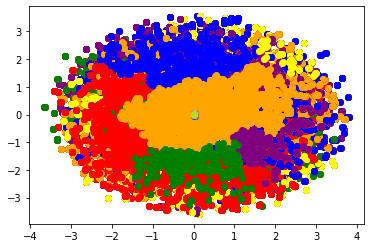

In [852]:
RandIndexKMeansPCACS = []
RandIndexDBSCANPCACS = []
RandIndexAgglomerativePCACS = []
RandIndexKMeanstSNECS = []
RandIndexDBSCANtSNECS = []
RandIndexAgglomerativetSNECS = []
TimeKMeansPCACS = []
TimeDBSCANPCACS = []
TimeAgglomerativePCACS = []
TimeKMeanstSNECS = []
TimeDBSCANtSNECS = []
TimeAgglomerativetSNECS =[]
seeds = [1,12,123,1234,12345,123456,1234567,12345678,123456789,1234567890]

datasettrue = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

data = datasettrue[0]

for i in range(0, 10):
    Agglomerative = []
    AgglomerativeTime = []
    print("SEED", i)
    print()
    np.random.seed(seeds[i])
    #K-MEANS PCA
    print("K-MEANS PCA")
    print()
    pca_2 = PCA(n_components=2)
    pca_2_result = pca_2.fit_transform(data.x.t())
    dataset_pca = pd.DataFrame(pca_2.components_,  index=['x', 'y'])
    dataset = dataset_pca.transpose()
    list1 = []
    for i in range(0, len(dataset)):
        list1.append([dataset.iloc[i, 0], dataset.iloc[i, 1]])
    list1 = np.array(list1)
    
    start = time.time()
    kmeans = KMeans(n_clusters = 4, n_init=200).fit(list1)
    end = time.time()
    label = kmeans.labels_
    plt.scatter(list1[label==0, 0], list1[label==0, 1], c='red', label ='Cluster 1')
    plt.scatter(list1[label==1, 0], list1[label==1, 1], c='blue', label ='Cluster 2')
    plt.scatter(list1[label==2, 0], list1[label==2, 1], c='orange', label ='Cluster 3')
    plt.scatter(list1[label==3, 0], list1[label==3, 1], c='yellow', label ='Cluster 4')
    RandIndexKMeansPCACS.append(accuracy(label, datasettrue))
    TimeKMeansPCACS.append(end-start)
    print()
    print("Agglomerative PCA Ward")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=4, linkage="ward")
    agglomerative.fit(list1)
    end = time.time()

    
    label2 = agglomerative.labels_
    plt.scatter(list1[label2==0, 0], list1[label2==0, 1], c='red', label ='Cluster 1')
    plt.scatter(list1[label2==1, 0], list1[label2==1, 1], c='blue', label ='Cluster 2')
    plt.scatter(list1[label2==2, 0], list1[label2==2, 1], c='orange', label ='Cluster 3')
    plt.scatter(list1[label2==3, 0], list1[label2==3, 1], c='yellow', label ='Cluster 4')
    
    Agglomerative.append(accuracy(label2, datasettrue))
    AgglomerativeTime.append(end-start)
    
    
    print()
    print("Agglomerative PCA Complete")
    print()
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=4, linkage="complete")
    agglomerative.fit(list1)
    end = time.time()

    label2 = agglomerative.labels_
    plt.scatter(list1[label2==0, 0], list1[label2==0, 1], c='red', label ='Cluster 1')
    plt.scatter(list1[label2==1, 0], list1[label2==1, 1], c='blue', label ='Cluster 2')
    plt.scatter(list1[label2==2, 0], list1[label2==2, 1], c='orange', label ='Cluster 3')
    plt.scatter(list1[label2==3, 0], list1[label2==3, 1], c='yellow', label ='Cluster 4')
    
    Agglomerative.append(accuracy(label2, datasettrue))
    AgglomerativeTime.append(end-start)
    
    print()
    print("Agglomerative PCA Single")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=4, linkage="single")
    agglomerative.fit(list1)
    end = time.time()

    label2 = agglomerative.labels_
    plt.scatter(list1[label2==0, 0], list1[label2==0, 1], c='red', label ='Cluster 1')
    plt.scatter(list1[label2==1, 0], list1[label2==1, 1], c='blue', label ='Cluster 2')
    plt.scatter(list1[label2==2, 0], list1[label2==2, 1], c='orange', label ='Cluster 3')
    plt.scatter(list1[label2==3, 0], list1[label2==3, 1], c='yellow', label ='Cluster 4')
    
    Agglomerative.append(accuracy(label2, datasettrue))
    AgglomerativeTime.append(end-start)
    
    print()
    print("Agglomerative PCA Average")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=4, linkage="average")
    agglomerative.fit(list1)
    end = time.time()

    label2 = agglomerative.labels_
    plt.scatter(list1[label2==0, 0], list1[label2==0, 1], c='red', label ='Cluster 1')
    plt.scatter(list1[label2==1, 0], list1[label2==1, 1], c='blue', label ='Cluster 2')
    plt.scatter(list1[label2==2, 0], list1[label2==2, 1], c='orange', label ='Cluster 3')
    plt.scatter(list1[label2==3, 0], list1[label2==3, 1], c='yellow', label ='Cluster 4')
    
    Agglomerative.append(accuracy(label2, datasettrue))
    AgglomerativeTime.append(end-start)
    
    RandIndexAgglomerativePCACS.append(Agglomerative)
    TimeAgglomerativePCACS.append(AgglomerativeTime)
    
    print()
    print("DBSCAN PCA")
    print()
    
    start = time.time()
    clustering = DBSCAN(eps=0.0020, min_samples=4).fit(list1)
    end = time.time()
    label4 = clustering.labels_

    unique, counts = np.unique(label4, return_counts = True)

    dict(zip(unique, counts))

    colours = ['red', 'blue', 'purple', 'pink', 'green', 'yellow', 'orange', 'black', 'brown', 'cyan', 'magenta', 'gray', 'silver', 'gold', 'teal']
    for i in range(0, len(unique)):
        plt.scatter(list1[label4==unique[i], 0], list1[label4 == unique[i],1], c =colours[i])

    
    RandIndexDBSCANPCACS.append(accuracy(label4, datasettrue))
    TimeDBSCANPCACS.append(end-start)
    
    print()
    print("K-Means tSNE")
    print()
    
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=57).fit_transform(data.x)
    dataset_tsne = pd.DataFrame(X_embedded, columns = ['x', 'y'])
    
    list2 = []
    for i in range(0, len(dataset_tsne)):
        list2.append([dataset_tsne.iloc[i, 0], dataset_tsne.iloc[i, 1]])
    
    list2 = np.array(list2)
    
    start = time.time()
    kmeans = KMeans(n_clusters = 6, n_init=200).fit(list2)
    end = time.time()
    label = kmeans.labels_
    
    plt.scatter(list2[label==0, 0], list2[label==0, 1], c='red', label ='Cluster 1')
    plt.scatter(list2[label==1, 0], list2[label==1, 1], c='blue', label ='Cluster 2')
    plt.scatter(list2[label==2, 0], list2[label==2, 1], c='orange', label ='Cluster 3')
    plt.scatter(list2[label==3, 0], list2[label==3, 1], c='yellow', label ='Cluster 4')
    plt.scatter(list2[label==4, 0], list2[label==4, 1], c='purple', label ='Cluster 5')
    plt.scatter(list2[label==5, 0], list2[label==5, 1], c='green', label ='Cluster 6')
    
    RandIndexKMeanstSNECS.append(accuracy(label, datasettrue))
    TimeKMeanstSNECS.append(end-start)
    
    print()
    print("Agglomerative tSNE ward")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=6, linkage="ward")
    agglomerative.fit(list2)
    end = time.time()

    label2 = agglomerative.labels_
    
    plt.scatter(list2[label2==0, 0], list2[label2==0, 1], c='red', label ='Cluster 1')
    plt.scatter(list2[label2==1, 0], list2[label2==1, 1], c='blue', label ='Cluster 2')
    plt.scatter(list2[label2==2, 0], list2[label2==2, 1], c='orange', label ='Cluster 3')
    plt.scatter(list2[label2==3, 0], list2[label2==3, 1], c='yellow', label ='Cluster 4')
    plt.scatter(list2[label2==4, 0], list2[label2==4, 1], c='purple', label ='Cluster 5')
    plt.scatter(list2[label2==5, 0], list2[label2==5, 1], c='green', label ='Cluster 6')
    
    Agglomerative = []
    AgglomerativeTime = []
    
    AgglomerativeTime.append(end-start)
    Agglomerative.append(accuracy(label2, datasettrue))
    
    print()
    print("Agglomerative tSNE Complete")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=6, linkage="complete")
    agglomerative.fit(list2)
    end = time.time()

    label2 = agglomerative.labels_
    
    plt.scatter(list2[label2==0, 0], list2[label2==0, 1], c='red', label ='Cluster 1')
    plt.scatter(list2[label2==1, 0], list2[label2==1, 1], c='blue', label ='Cluster 2')
    plt.scatter(list2[label2==2, 0], list2[label2==2, 1], c='orange', label ='Cluster 3')
    plt.scatter(list2[label2==3, 0], list2[label2==3, 1], c='yellow', label ='Cluster 4')
    plt.scatter(list2[label2==4, 0], list2[label2==4, 1], c='purple', label ='Cluster 5')
    plt.scatter(list2[label2==5, 0], list2[label2==5, 1], c='green', label ='Cluster 6')
    
    AgglomerativeTime.append(end-start)
    Agglomerative.append(accuracy(label2, datasettrue))
    
    print()
    print("Agglomerative tSNE single")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=6, linkage="single")
    agglomerative.fit(list2)
    end = time.time()

    label2 = agglomerative.labels_
    
    plt.scatter(list2[label2==0, 0], list2[label2==0, 1], c='red', label ='Cluster 1')
    plt.scatter(list2[label2==1, 0], list2[label2==1, 1], c='blue', label ='Cluster 2')
    plt.scatter(list2[label2==2, 0], list2[label2==2, 1], c='orange', label ='Cluster 3')
    plt.scatter(list2[label2==3, 0], list2[label2==3, 1], c='yellow', label ='Cluster 4')
    plt.scatter(list2[label2==4, 0], list2[label2==4, 1], c='purple', label ='Cluster 5')
    plt.scatter(list2[label2==5, 0], list2[label2==5, 1], c='green', label ='Cluster 6')
    
    AgglomerativeTime.append(end-start)
    Agglomerative.append(accuracy(label2, datasettrue))
    
    print()
    print("Agglomerative tSNE average")
    print()
    
    start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=6, linkage="average")
    agglomerative.fit(list2)
    end = time.time()

    label2 = agglomerative.labels_
    
    plt.scatter(list2[label2==0, 0], list2[label2==0, 1], c='red', label ='Cluster 1')
    plt.scatter(list2[label2==1, 0], list2[label2==1, 1], c='blue', label ='Cluster 2')
    plt.scatter(list2[label2==2, 0], list2[label2==2, 1], c='orange', label ='Cluster 3')
    plt.scatter(list2[label2==3, 0], list2[label2==3, 1], c='yellow', label ='Cluster 4')
    plt.scatter(list2[label2==4, 0], list2[label2==4, 1], c='purple', label ='Cluster 5')
    plt.scatter(list2[label2==5, 0], list2[label2==5, 1], c='green', label ='Cluster 6')
    
    AgglomerativeTime.append(end-start)
    Agglomerative.append(accuracy(label2, datasettrue))
    
    TimeAgglomerativetSNECS.append(AgglomerativeTime)
    RandIndexAgglomerativetSNECS.append(Agglomerative)
    
    print()
    print("DBSCAN tSNE")
    print()
    
    start = time.time()
    clustering = DBSCAN(eps=0.13, min_samples=4).fit(list2)
    end = time.time()
    label4 = clustering.labels_

    unique, counts = np.unique(label4, return_counts = True)

    dict(zip(unique, counts))

    number_of_colors = len(unique)

    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    for i in range(0, len(unique)):
        plt.scatter(list1[label4==unique[i], 0], list1[label4 == unique[i],1], c = color[i])
        listcolor.append(color)
        
    
    RandIndexDBSCANtSNECS.append(accuracy(label4, datasettrue))
    TimeDBSCANtSNECS.append(end-start)
    
    
    
    
    
    
    
    
    
    

In [855]:
print(RandIndexKMeansPCACS)
print()
print(RandIndexDBSCANPCACS)
print()
print(RandIndexAgglomerativePCACS)
print()
print(RandIndexKMeanstSNECS)
print()
print(RandIndexDBSCANtSNECS)
print()
print(RandIndexAgglomerativetSNECS)
print()
print(TimeKMeansPCACS)
print()
print(TimeDBSCANPCACS)
print()
print(TimeAgglomerativePCACS)
print()
print(TimeKMeanstSNECS)
print()
print(TimeDBSCANtSNECS)
print()
print(TimeAgglomerativetSNECS)

[0.4204989480012023, 0.4220018034265104, 0.4220018034265104, 0.42140066125638714, 0.4211000901713255, 0.42170123234144874, 0.42170123234144874, 0.4220018034265104, 0.4207995190862639, 0.4220018034265104]

[0.21220318605350166, 0.21250375713856326, 0.21250375713856326, 0.21250375713856326, 0.2131048993086865, 0.21250375713856326, 0.21250375713856326, 0.2131048993086865, 0.21250375713856326, 0.21220318605350166]

[[0.40937781785392247, 0.2852419597234746, 0.21070033062819357, 0.3261196272918545], [0.40547039374812144, 0.3134956417192666, 0.21070033062819357, 0.31920649233543735], [0.4259092275323114, 0.37962128043282234, 0.21070033062819357, 0.3826269912834385], [0.41839495040577096, 0.3700030057108506, 0.21070033062819357, 0.35978358881875566], [0.42140066125638714, 0.3624887285843102, 0.21070033062819357, 0.35617673579801623], [0.4162909528103396, 0.34385332131048996, 0.21070033062819357, 0.3480613165013526], [0.41989780583107905, 0.3432521791403667, 0.21070033062819357, 0.346257889990

# Other plots - Cora

## K-Means (PCA) seed 12345

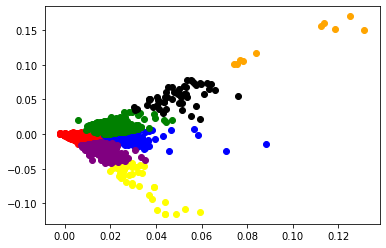

In [1015]:
datasettrue = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

data = datasettrue[0]
np.random.seed(12345)
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(data.x.t())
dataset_pca = pd.DataFrame(pca_2.components_,  index=['x', 'y'])
dataset = dataset_pca.transpose()
list1 = []
for i in range(0, len(dataset)):
    list1.append([dataset.iloc[i, 0], dataset.iloc[i, 1]])
list1 = np.array(list1)

kmeans = KMeans(n_clusters = 7, n_init=200).fit(list1)
   
label = kmeans.labels_
plt.scatter(list1[label==0, 0], list1[label==0, 1], c='red', label ='Cluster 1')
plt.scatter(list1[label==1, 0], list1[label==1, 1], c='blue', label ='Cluster 2')
plt.scatter(list1[label==2, 0], list1[label==2, 1], c='orange', label ='Cluster 3')
plt.scatter(list1[label==3, 0], list1[label==3, 1], c='yellow', label ='Cluster 4')
plt.scatter(list1[label==4, 0], list1[label==4, 1], c='purple', label ='Cluster 5')
plt.scatter(list1[label==5, 0], list1[label==5, 1], c='green', label ='Cluster 6')
plt.scatter(list1[label==6, 0], list1[label==6, 1], c='black', label ='Cluster 7')

## K-Means (t-SNE) seed 12345678

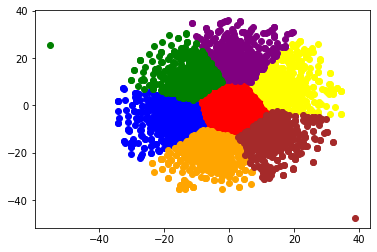

In [10]:
datasettrue = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

data = datasettrue[0]
np.random.seed(12345678)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=52).fit_transform(data.x)
dataset_tsne = pd.DataFrame(X_embedded, columns = ['x', 'y'])
    
list2 = []
for i in range(0, len(dataset_tsne)):
    list2.append([dataset_tsne.iloc[i, 0], dataset_tsne.iloc[i, 1]])
    
list2 = np.array(list2)
    
kmeans = KMeans(n_clusters = 7, n_init=200).fit(list2)
label = kmeans.labels_
    
plt.scatter(list2[label==0, 0], list2[label==0, 1], c='red', label ='Cluster 1')
plt.scatter(list2[label==1, 0], list2[label==1, 1], c='blue', label ='Cluster 2')
plt.scatter(list2[label==2, 0], list2[label==2, 1], c='orange', label ='Cluster 3')
plt.scatter(list2[label==3, 0], list2[label==3, 1], c='yellow', label ='Cluster 4')
plt.scatter(list2[label==4, 0], list2[label==4, 1], c='purple', label ='Cluster 5')
plt.scatter(list2[label==5, 0], list2[label==5, 1], c='green', label ='Cluster 6')
plt.scatter(list2[label==6, 0], list2[label==6, 1], c='brown', label ='Cluster 7')

## DBSCAN (PCA) seed 1

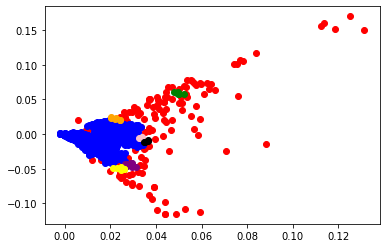

In [14]:
datasettrue = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

data = datasettrue[0]
np.random.seed(1)
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(data.x.t())
dataset_pca = pd.DataFrame(pca_2.components_,  index=['x', 'y'])
dataset = dataset_pca.transpose()
list1 = []
for i in range(0, len(dataset)):
    list1.append([dataset.iloc[i, 0], dataset.iloc[i, 1]])
list1 = np.array(list1)

clustering = DBSCAN(eps=0.0025, min_samples=4).fit(list1)
label4 = clustering.labels_

unique, counts = np.unique(label4, return_counts = True)

dict(zip(unique, counts))

colours = ['red', 'blue', 'purple', 'pink', 'green', 'yellow', 'orange', 'black', 'brown', 'cyan', 'magenta', 'gray', 'silver', 'gold', 'teal']
for i in range(0, len(unique)):
    plt.scatter(list1[label4==unique[i], 0], list1[label4 == unique[i],1], c =colours[i])

Red points are noise points.

## DBSCAN (t-SNE) seed 123

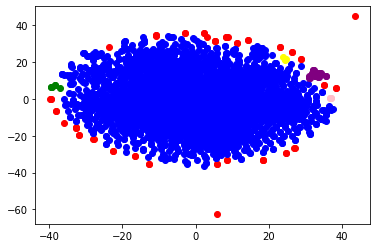

In [15]:
datasettrue = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

data = datasettrue[0]
np.random.seed(123)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=52).fit_transform(data.x)
dataset_tsne = pd.DataFrame(X_embedded, columns = ['x', 'y'])
    
list2 = []
for i in range(0, len(dataset_tsne)):
    list2.append([dataset_tsne.iloc[i, 0], dataset_tsne.iloc[i, 1]])
    
list2 = np.array(list2)

clustering = DBSCAN(eps=3, min_samples=4).fit(list2)
label4 = clustering.labels_
unique, counts = np.unique(label4, return_counts = True)

dict(zip(unique, counts))
    
for i in range(0, len(unique)):
    plt.scatter(list2[label4==unique[i], 0], list2[label4 == unique[i],1], c =colours[i])

Red points are noise points.

## Agglomerative (PCA) seed 1 - Average linkage

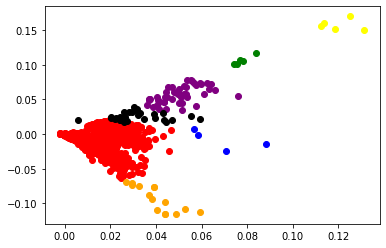

In [16]:
datasettrue = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

data = datasettrue[0]
np.random.seed(1)
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(data.x.t())
dataset_pca = pd.DataFrame(pca_2.components_,  index=['x', 'y'])
dataset = dataset_pca.transpose()
list1 = []
for i in range(0, len(dataset)):
    list1.append([dataset.iloc[i, 0], dataset.iloc[i, 1]])
list1 = np.array(list1)

agglomerative = AgglomerativeClustering(n_clusters=7, linkage="average")
agglomerative.fit(list1)
label2 = agglomerative.labels_
    
plt.scatter(list1[label2==0, 0], list1[label2==0, 1], c='red', label ='Cluster 1')
plt.scatter(list1[label2==1, 0], list1[label2==1, 1], c='blue', label ='Cluster 2')
plt.scatter(list1[label2==2, 0], list1[label2==2, 1], c='orange', label ='Cluster 3')
plt.scatter(list1[label2==3, 0], list1[label2==3, 1], c='yellow', label ='Cluster 4')
plt.scatter(list1[label2==4, 0], list1[label2==4, 1], c='purple', label ='Cluster 5')
plt.scatter(list1[label2==5, 0], list1[label2==5, 1], c='green', label ='Cluster 6')
plt.scatter(list1[label2==6, 0], list1[label2==6, 1], c='black', label ='Cluster 7')

## Agglomerative (t-SNE) seed 123456 - Ward linkage

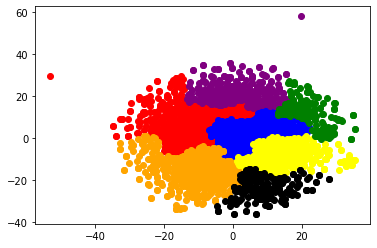

In [1053]:
datasettrue = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

data = datasettrue[0]
np.random.seed(123456)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=52).fit_transform(data.x)
dataset_tsne = pd.DataFrame(X_embedded, columns = ['x', 'y'])
    
list2 = []
for i in range(0, len(dataset_tsne)):
    list2.append([dataset_tsne.iloc[i, 0], dataset_tsne.iloc[i, 1]])
    
list2 = np.array(list2)

agglomerative = AgglomerativeClustering(n_clusters=7, linkage="ward")
agglomerative.fit(list2)
label2 = agglomerative.labels_
    
plt.scatter(list2[label2==0, 0], list2[label2==0, 1], c='red', label ='Cluster 1')
plt.scatter(list2[label2==1, 0], list2[label2==1, 1], c='blue', label ='Cluster 2')
plt.scatter(list2[label2==2, 0], list2[label2==2, 1], c='orange', label ='Cluster 3')
plt.scatter(list2[label2==3, 0], list2[label2==3, 1], c='yellow', label ='Cluster 4')
plt.scatter(list2[label2==4, 0], list2[label2==4, 1], c='purple', label ='Cluster 5')
plt.scatter(list2[label2==5, 0], list2[label2==5, 1], c='green', label ='Cluster 6')
plt.scatter(list2[label2==6, 0], list2[label2==6, 1], c='black', label ='Cluster 7')

# Other plots - Citeseer

## K-Means (PCA) seed 12

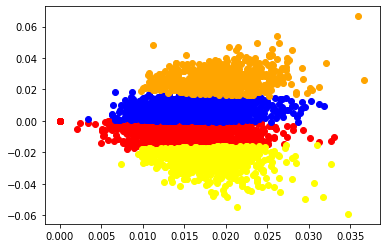

In [1034]:
datasettrue = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

data = datasettrue[0]
np.random.seed(12)
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(data.x.t())
dataset_pca = pd.DataFrame(pca_2.components_,  index=['x', 'y'])
dataset = dataset_pca.transpose()
list1 = []
for i in range(0, len(dataset)):
    list1.append([dataset.iloc[i, 0], dataset.iloc[i, 1]])
list1 = np.array(list1)

kmeans = KMeans(n_clusters = 4, n_init=200).fit(list1)
   
label = kmeans.labels_
plt.scatter(list1[label==0, 0], list1[label==0, 1], c='red', label ='Cluster 1')
plt.scatter(list1[label==1, 0], list1[label==1, 1], c='blue', label ='Cluster 2')
plt.scatter(list1[label==2, 0], list1[label==2, 1], c='orange', label ='Cluster 3')
plt.scatter(list1[label==3, 0], list1[label==3, 1], c='yellow', label ='Cluster 4')

## K-Means (t-SNE) seed 12

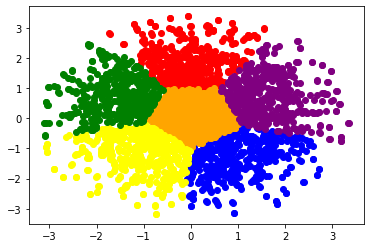

In [1036]:
datasettrue = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

data = datasettrue[0]
np.random.seed(12)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=57).fit_transform(data.x)
dataset_tsne = pd.DataFrame(X_embedded, columns = ['x', 'y'])
    
list2 = []
for i in range(0, len(dataset_tsne)):
    list2.append([dataset_tsne.iloc[i, 0], dataset_tsne.iloc[i, 1]])
    
list2 = np.array(list2)
    
kmeans = KMeans(n_clusters = 6, n_init=200).fit(list2)
label = kmeans.labels_
    
plt.scatter(list2[label==0, 0], list2[label==0, 1], c='red', label ='Cluster 1')
plt.scatter(list2[label==1, 0], list2[label==1, 1], c='blue', label ='Cluster 2')
plt.scatter(list2[label==2, 0], list2[label==2, 1], c='orange', label ='Cluster 3')
plt.scatter(list2[label==3, 0], list2[label==3, 1], c='yellow', label ='Cluster 4')
plt.scatter(list2[label==4, 0], list2[label==4, 1], c='purple', label ='Cluster 5')
plt.scatter(list2[label==5, 0], list2[label==5, 1], c='green', label ='Cluster 6')

## DBSCAN (PCA) seed 12345

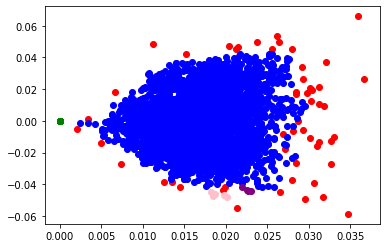

In [1039]:
datasettrue = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

data = datasettrue[0]
np.random.seed(12345)
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(data.x.t())
dataset_pca = pd.DataFrame(pca_2.components_,  index=['x', 'y'])
dataset = dataset_pca.transpose()
list1 = []
for i in range(0, len(dataset)):
    list1.append([dataset.iloc[i, 0], dataset.iloc[i, 1]])
list1 = np.array(list1)

clustering = DBSCAN(eps=0.0020, min_samples=4).fit(list1)
label4 = clustering.labels_

unique, counts = np.unique(label4, return_counts = True)

dict(zip(unique, counts))

colours = ['red', 'blue', 'purple', 'pink', 'green', 'yellow', 'orange', 'black', 'brown', 'cyan', 'magenta', 'gray', 'silver', 'gold', 'teal']
for i in range(0, len(unique)):
    plt.scatter(list1[label4==unique[i], 0], list1[label4 == unique[i],1], c =colours[i])

## DBSCAN (t-SNE) seed 1234

In [19]:
import random

In [20]:
datasettrue = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

data = datasettrue[0]
np.random.seed(1234)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=57).fit_transform(data.x)
dataset_tsne = pd.DataFrame(X_embedded, columns = ['x', 'y'])
    
list2 = []
for i in range(0, len(dataset_tsne)):
    list2.append([dataset_tsne.iloc[i, 0], dataset_tsne.iloc[i, 1]])
    
list2 = np.array(list2)

clustering = DBSCAN(eps=0.13, min_samples=4).fit(list2)
label4 = clustering.labels_
unique, counts = np.unique(label4, return_counts = True)

    
number_of_colors = len(unique)


#65C6FB


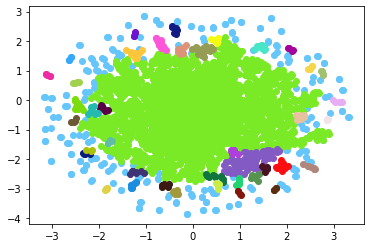

In [22]:
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])for i in range(number_of_colors)]
for i in range(0, len(unique)):
    plt.scatter(list2[label4==unique[i], 0], list2[label4 == unique[i],1], c = color[i])
    if i == 0:
        print(color[i])

## Agglomerative (PCA) seed 123 - ward

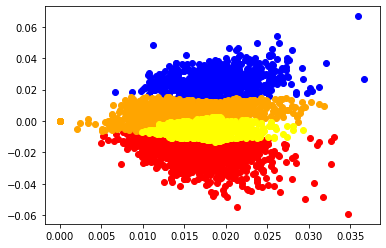

In [23]:
datasettrue = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

data = datasettrue[0]
np.random.seed(123)
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(data.x.t())
dataset_pca = pd.DataFrame(pca_2.components_,  index=['x', 'y'])
dataset = dataset_pca.transpose()
list1 = []
for i in range(0, len(dataset)):
    list1.append([dataset.iloc[i, 0], dataset.iloc[i, 1]])
list1 = np.array(list1)

agglomerative = AgglomerativeClustering(n_clusters=4, linkage="ward")
agglomerative.fit(list1)
label2 = agglomerative.labels_
    
plt.scatter(list1[label2==0, 0], list1[label2==0, 1], c='red', label ='Cluster 1')
plt.scatter(list1[label2==1, 0], list1[label2==1, 1], c='blue', label ='Cluster 2')
plt.scatter(list1[label2==2, 0], list1[label2==2, 1], c='orange', label ='Cluster 3')
plt.scatter(list1[label2==3, 0], list1[label2==3, 1], c='yellow', label ='Cluster 4')

## Agglomerative (t-SNE) seed 123 - ward linkage

In [24]:
datasettrue = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

data = datasettrue[0]
np.random.seed(123)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=57).fit_transform(data.x)
dataset_tsne = pd.DataFrame(X_embedded, columns = ['x', 'y'])
    
list2 = []
for i in range(0, len(dataset_tsne)):
    list2.append([dataset_tsne.iloc[i, 0], dataset_tsne.iloc[i, 1]])
    
list2 = np.array(list2)


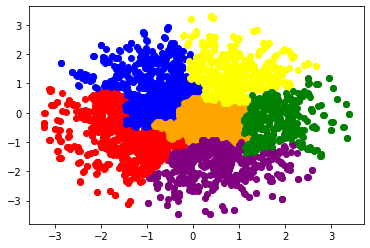

In [25]:
agglomerative = AgglomerativeClustering(n_clusters=6, linkage="ward")
agglomerative.fit(list2)
label2 = agglomerative.labels_
    
plt.scatter(list2[label2==0, 0], list2[label2==0, 1], c='red', label ='Cluster 1')
plt.scatter(list2[label2==1, 0], list2[label2==1, 1], c='blue', label ='Cluster 2')
plt.scatter(list2[label2==2, 0], list2[label2==2, 1], c='orange', label ='Cluster 3')
plt.scatter(list2[label2==3, 0], list2[label2==3, 1], c='yellow', label ='Cluster 4')
plt.scatter(list2[label2==4, 0], list2[label2==4, 1], c='purple', label ='Cluster 5')
plt.scatter(list2[label2==5, 0], list2[label2==5, 1], c='green', label ='Cluster 6')